# Periodic boundary conditions I (structure)

## Overview

In this session, we will learn how to compute structural quantities from an MD simulation. 

### Questions

- What are PBCs? What is the minimum image convention? What are images?
- How do I assess the structure of a liquid?
- How do I compute structural quantities of polymers from a MD simulation?

### Objectives

- Write a function that computes the correct distance in PBC.
- Calculate the radial distribution function of a system. 
- Calculate the radius of gyration of a polymer.
- Show that the simple polymer model agrees with scaling expectations (Rouse model).

## Boilerplate code

In [1]:
import matplotlib
import numpy 
import scipy.stats
import gsd, gsd.hoomd 
import freud 
import math
import itertools 
import hoomd 
# for movie/renders
import fresnel 
import PIL 
import io 
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display 

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

def render(frame):
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5)
    geometry.position[:] = frame.particles.position
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, frame.configuration.box,box_radius=0.01)
    L = frame.configuration.box[0]
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

    scene.background_color =(1,1,1)
    scene.background_alpha = 1
    if frame.bonds.N>0:
        geometry.radius[:] = [0.2]*frame.particles.N 

        all_bonds = numpy.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
        )
        # Use a distance cutoff (L/2) to filter bonds that span the periodic boundary
        bond_distances = numpy.linalg.norm(all_bonds[:,0,:]-all_bonds[:,1,:], axis=1)
        L = frame.configuration.box[0]
        bond_indices = numpy.where(bond_distances < L/2)[0]
        filtered_bonds = all_bonds[bond_indices, :, :]
        
        bonds = fresnel.geometry.Cylinder(scene, N=len(filtered_bonds))
        bonds.material = fresnel.material.Material(roughness=0.5)
        bonds.outline_width = 0.05

        bonds.points[:] = filtered_bonds
        bonds.radius[:] = [0.1]*len(filtered_bonds)
        bonds.material.primitive_color_mix = 1.0
        bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
                
    return fresnel.preview(scene)

# Boundary Conditions - Structure 

## Minimum Image Convention 

Write a function `dist(..)` that computes the distances between points in 3D without periodic boundary conditions. Then write one that does take periodic boundary conditions into account, `dist_pbc(..)`. Your functions should work for arrays of positions (which might contain one or more points) and return an array of distances. 

*Hint:* feel free to use numpy (`numpy.where`, `numpy.linalg.norm`, `numpy.sqrt`, `numpy.abs`,..) functions.

We assume **hoomd** conventions, meaning the box coordinates are defined from `(-Li/2,+Li/2)` (with `i` = x,y, or z) and the origin of the box is at `(0,0,0)`.

In [2]:
def dist(x1,x0):
    delta = x1 - x0
    return numpy.linalg.norm(delta,axis=1)

def dist_pbc(x1,x0,Box):
    delta = x1 - x0
    delta =  numpy.where(delta > 0.5 * Box, Box - delta,  numpy.where(delta <- 0.5 * Box, Box + delta, delta))
    return numpy.linalg.norm(delta,axis=1)

Test your functions with points in 3D:

In [3]:
Box = numpy.array([10,10,10])

points_A = numpy.array([[2,3,1]])
points_B = numpy.array([[0,0,0],[-1,-4,0],[-4,2,3],[3,5,-4]])
points_C = numpy.array([[3,0,-2],[2,-2,4],[2,0,0],[0,0,5]])
points_D = numpy.array([[-1,0,0]])

print(dist_pbc(points_A,points_B,Box))
print(dist(points_A,points_B))

print(dist_pbc(points_B,points_C,Box))
print(dist(points_B,points_C))

print(dist_pbc(points_A,points_A,Box))
print(dist_pbc([points_B[0]],points_D,Box))


[3.74165739 4.35889894 4.58257569 5.47722558]
[3.74165739 7.68114575 6.40312424 5.47722558]
[3.60555128 5.38516481 5.38516481 5.91607978]
[ 3.60555128  5.38516481  7.         10.72380529]
[0.]
[1.]


### Additions 

Try to come up with alternative ways to calculate the minimum distance: 
1. use `if` statements
2. use `floor/round`
3. use other `numpy` functions
4. ....

## Radial Distribution Function

Now we want to compute the radial distribution function. For this we will use the minium distance functions from above, so make sure they are correct before proceeding! 

It is useful to use `numpy.histogram` for this task, since we effectively are computing a radial histogram. Normalized correctly, this will give us the radial distribution function. 

First, write a function that returns the correct normalization for an array of distances `r`, as function of `N` and the `Box`.  

In [4]:
# https://en.wikibooks.org/wiki/Molecular_Simulation/Radial_Distribution_Functions
# https://en.wikipedia.org/wiki/Radial_distribution_function

def norm(Box,N,r):
    rho=N/Box.prod()
    dr=r[1]-r[0]
    norm=rho*4.0*numpy.pi*r**2.0*dr
    return norm

Now write a function that takes two arrays `A`,`B` of points, a `Box`, number of bins `number_of_bins`, and a maximum distance `rmax` and returns the pair correlation function as a histogram and the corresponding bin centers. 

In [5]:
def pair_corr(A,B,Box,number_of_bins,rmax):

    bins = numpy.linspace(0,rmax,num=(number_of_bins+1))
    hist_all, bin_edges_all = numpy.histogram(0,bins)

    for index in range(len(A)):
        d = dist_pbc(A[index],B,Box)
        hist, bin_edges = numpy.histogram(d,bins)
        hist_all += hist

    bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
    n=norm(Box,len(A),bincenters)
    hist_all=hist_all/(n*len(B))
    hist_all[0]=0
    return bincenters,hist_all

## Short LJ Simulation 

Now we need to test our code. For this, we will run a short LJ simulation. For simplicity, we use a simple cubic as starting configuration. let's put some particles on a simple cubic lattice into a box. Define the starting `Frame`: 

In [6]:

frame = gsd.hoomd.Frame()

L = 12
spacing = 1.05
x = numpy.linspace(-0.5*L, 0.5*L, int(L/spacing), endpoint=False)
position = list(itertools.product(x, repeat=3))

frame.particles.N = len(position)
frame.particles.position = position
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ['A']


Render the frame and check that it is correct:

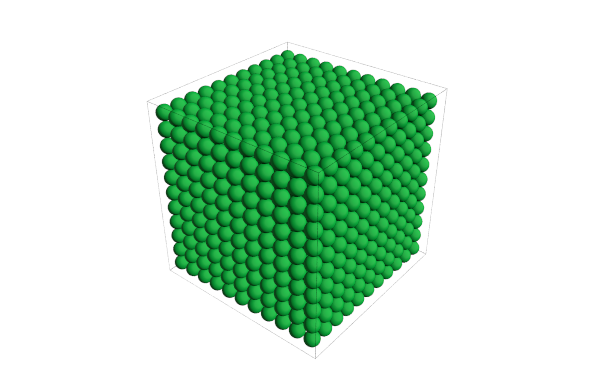

In [7]:
render(frame)

Let's compute the radial distribution function of that simple cubic configuration: 

Text(0.5, 0, 'r')

Text(0, 0.5, 'g(r)')

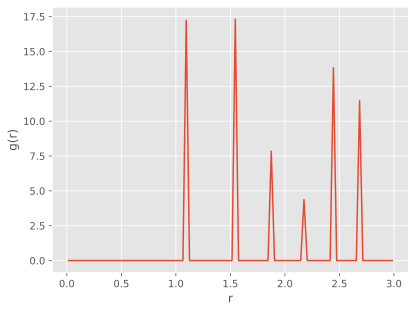

In [8]:
box = numpy.array([L,L,L])
c,hist = pair_corr(numpy.asarray(position),numpy.asarray(position),box,100,L/4.)
fig, ax = matplotlib.pyplot.subplots()
ax.plot(c,hist)
ax.set_xlabel('r')
ax.set_ylabel('g(r)')
matplotlib.pyplot.show()

### Run the Simulation 

Now we can run a short simulation at temperature $1\,k_BT$, which should melt the simple cubic into a liquid:  

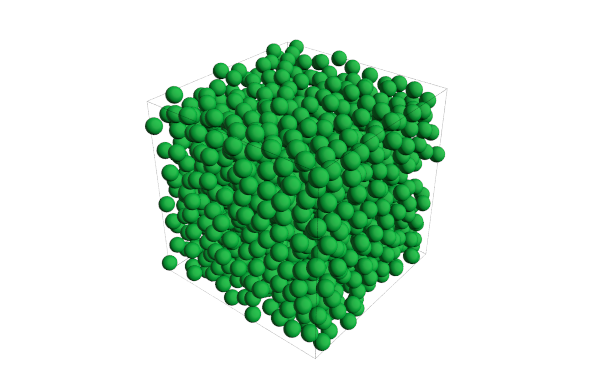

In [9]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
LJ = hoomd.md.pair.LJ(nlist=cell)
LJ.params[("A", "A")] = dict(epsilon=1, sigma=1)
LJ.r_cut[("A", "A")] = 3.0
integrator.forces.append(LJ)

simulation = hoomd.Simulation(device=hoomd.device.auto_select(),seed=42)
simulation.operations.integrator = integrator 
simulation.create_state_from_snapshot(frame)

nve = hoomd.md.methods.Langevin(filter=hoomd.filter.All(),kT=1)
integrator.methods.append(nve)
simulation.operations.integrator = integrator 

gsd_out = hoomd.write.GSD(
    trigger=hoomd.trigger.Periodic(100), 
    mode='wb',
    filename='example_lj.gsd')

simulation.operations.writers.append(gsd_out)

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1)
simulation.run(10000)
gsd_out.flush()
render(simulation.state.get_snapshot())


Now we can measure the $g(r)$ of the liquid by taking the end of the trajecory and averaging the radial distribution function of those snapshots: 

In [10]:
trajectory =  gsd.hoomd.open(name='example_lj.gsd', mode='r')
box = trajectory[0].configuration.box[0:3]
h = []
# take just last 30 snapshots
for frame in trajectory[-30:]:
    pos = frame.particles.position
    c,hist = pair_corr(pos,pos,box,50,box[0]/4.)
    h.append(hist)

Now we need to plot the results:

Text(0.5, 0, 'r')

Text(0, 0.5, 'g(r)')

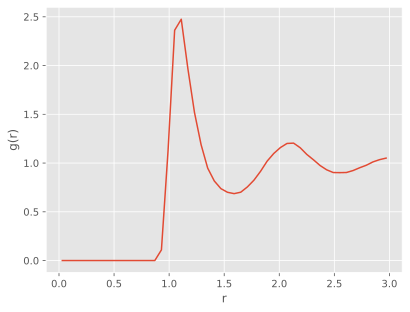

In [11]:
fig, ax = matplotlib.pyplot.subplots()
hist_averaged = numpy.average(h,axis=0)
ax.plot(c,hist_averaged)
ax.set_xlabel('r')
ax.set_ylabel('g(r)')
matplotlib.pyplot.show()

### Freud - Radial Distribution Function

It is always advisable to know exactly what you analyze and calculate from a simulation, so the exercise above lets us compute $g(r)$ and check our code and understanding. However, often, this might be quite slow and eventually cumbersome. There are many packages that allow us to compute certain standard properties from simulations without needing to implement everything ourselves. **Freud** (https://freud.readthedocs.io/) is such a package. Check the freud documentation on $g(r)$, https://freud.readthedocs.io/en/latest/modules/density.html#freud.density.RDF. You might find the tutorial on radial distribution function helpful as well: https://freud.readthedocs.io/en/latest/gettingstarted/examples/module_intros/density.RDF-AccumulateFluid.html

With this knowledge, write code that computes $g(r)$ using freud: 

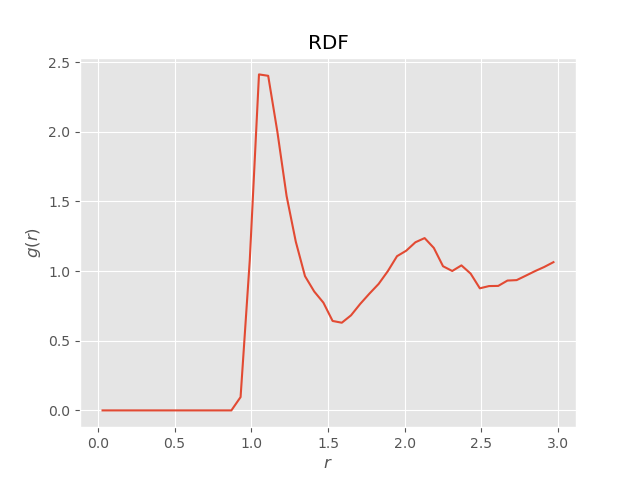

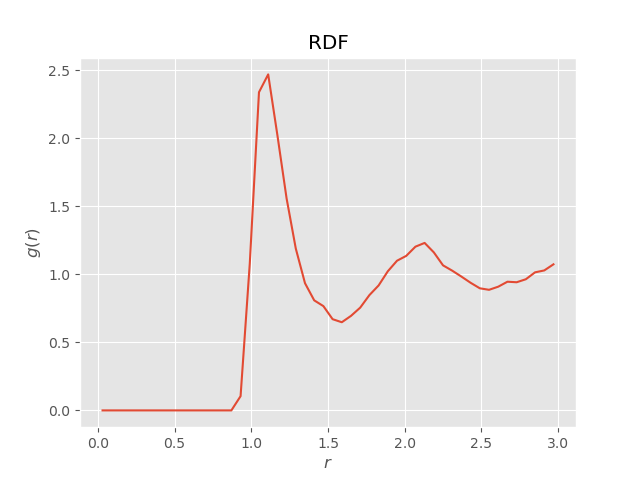

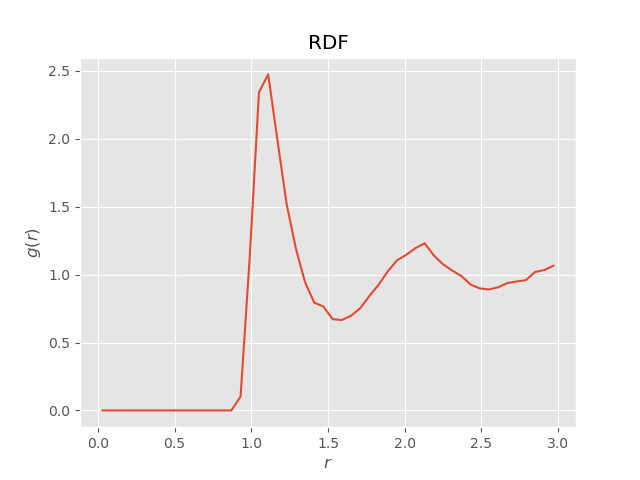

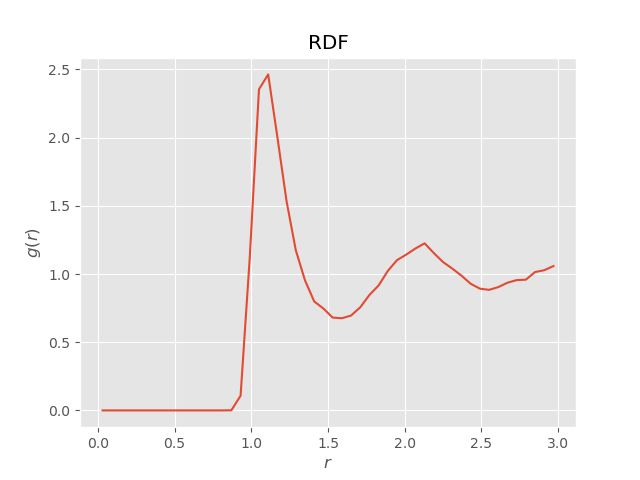

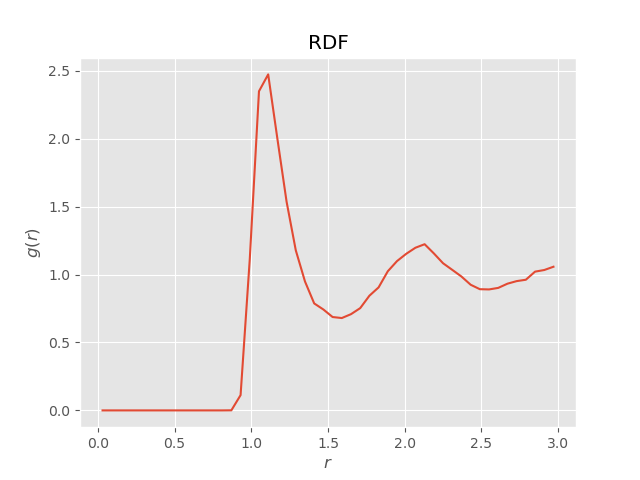

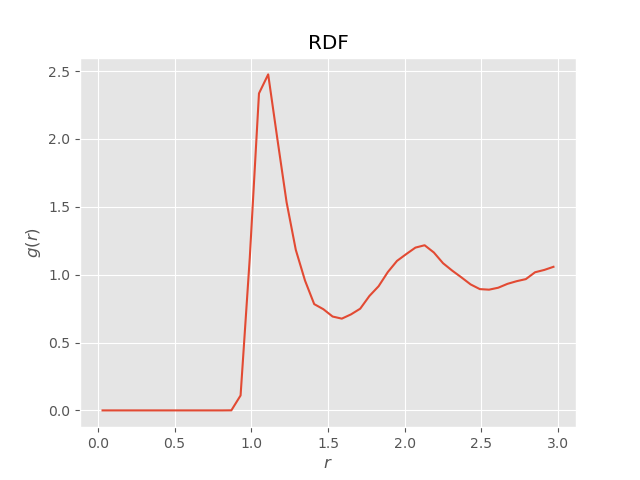

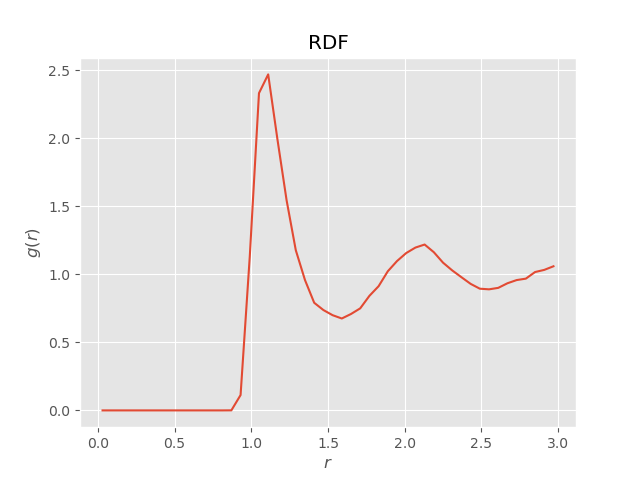

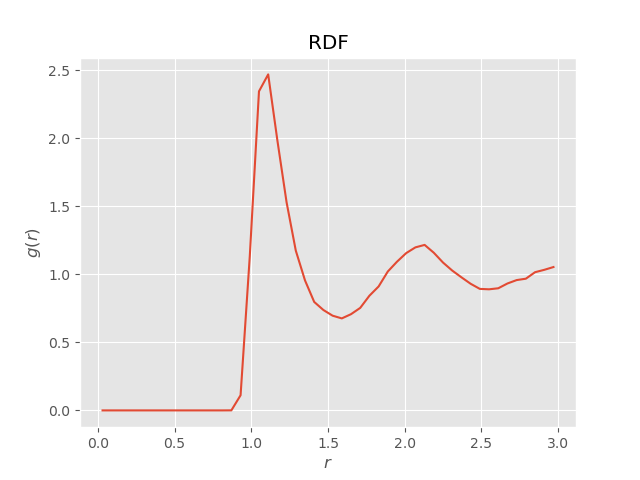

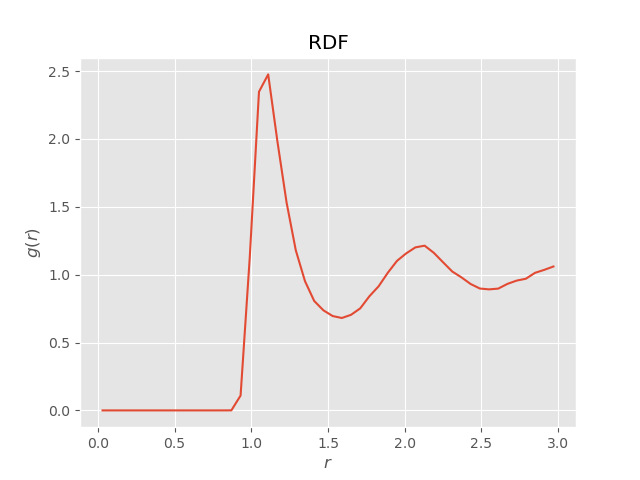

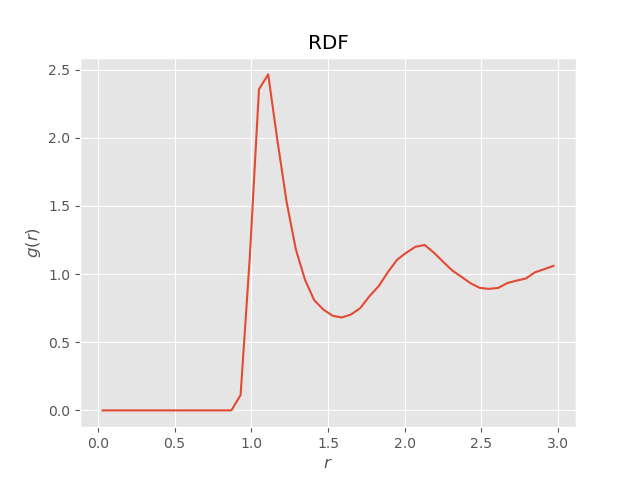

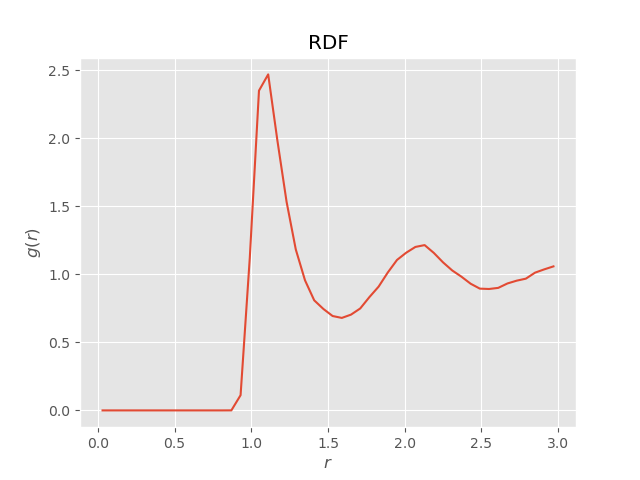

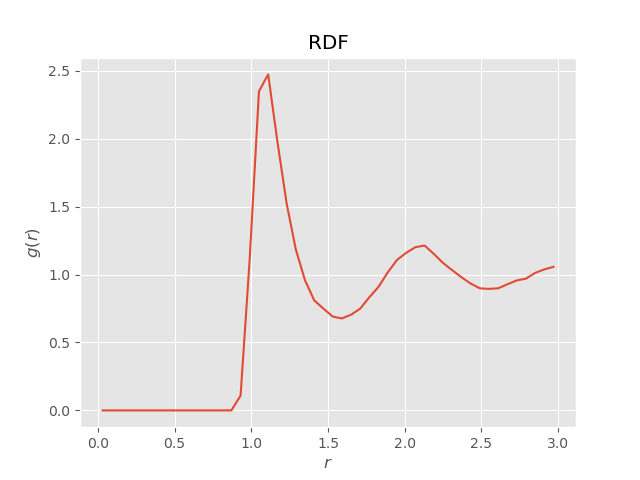

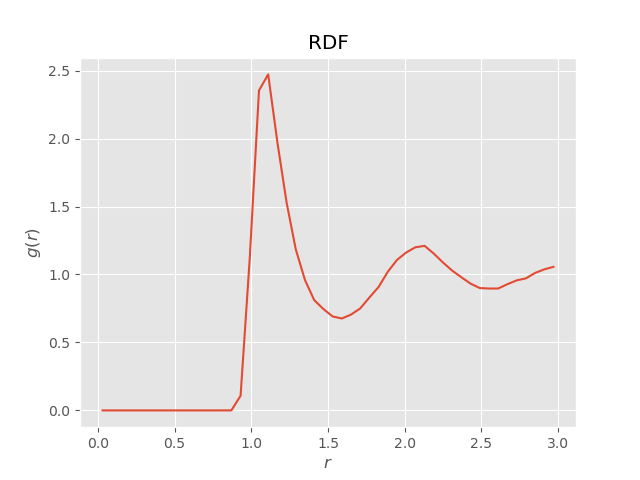

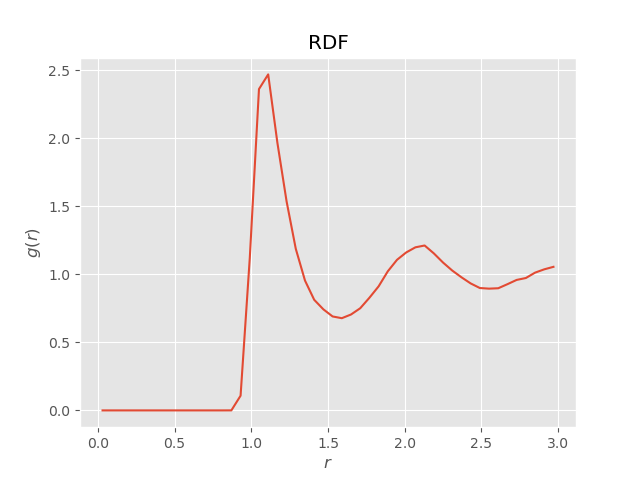

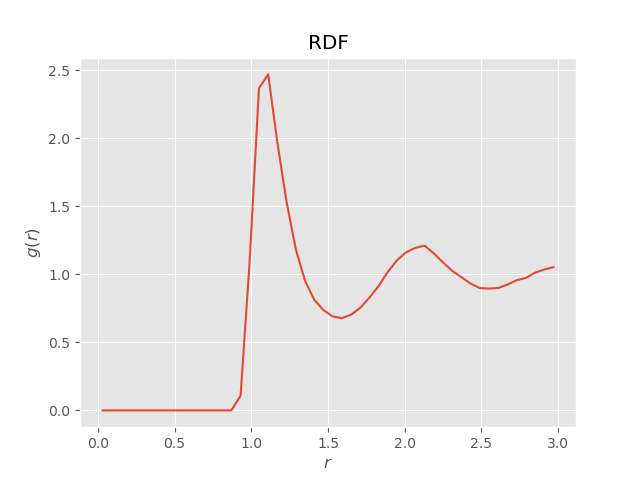

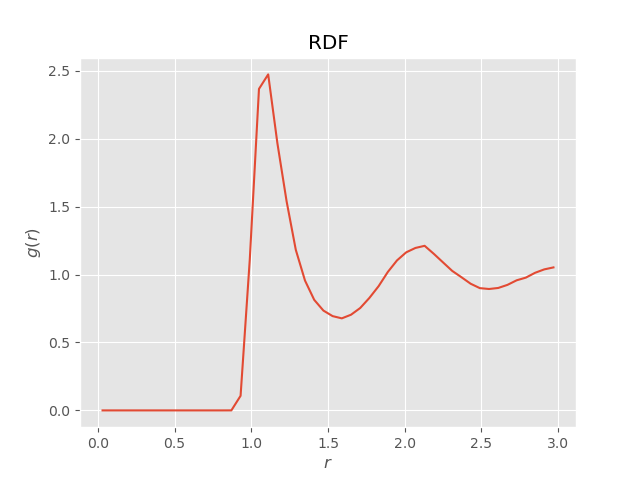

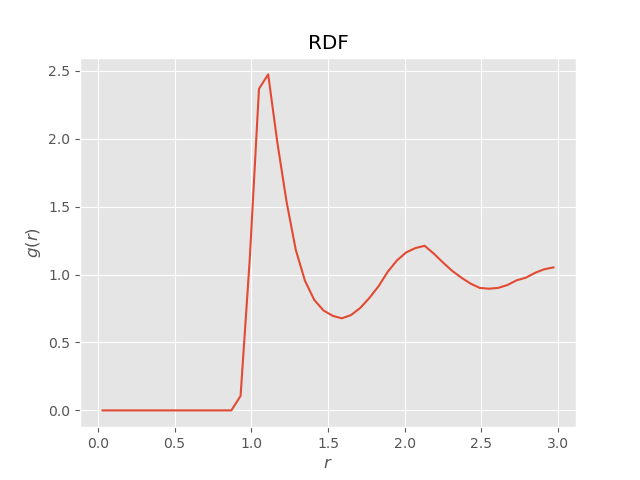

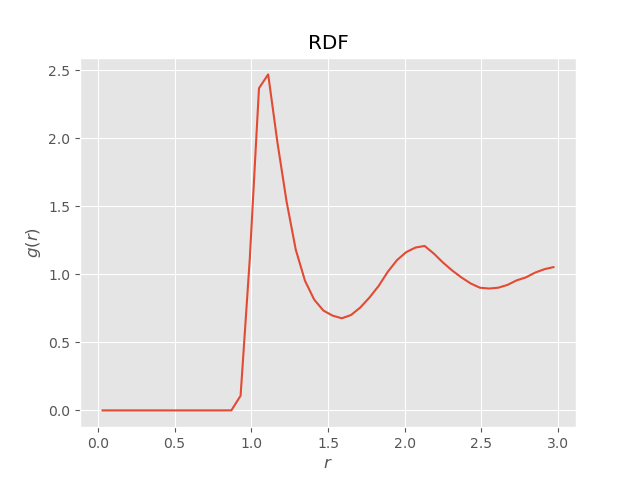

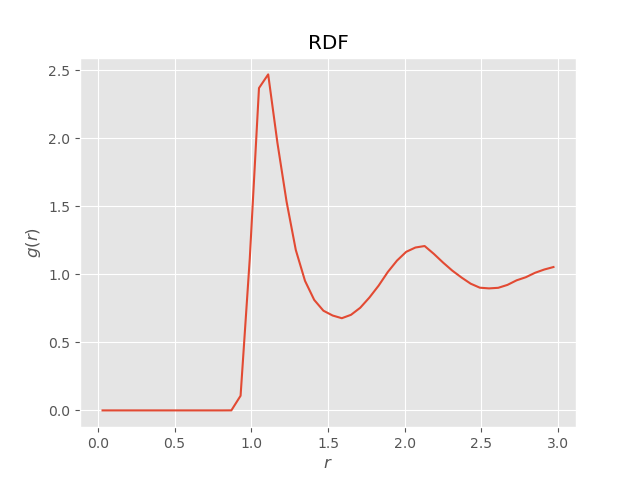

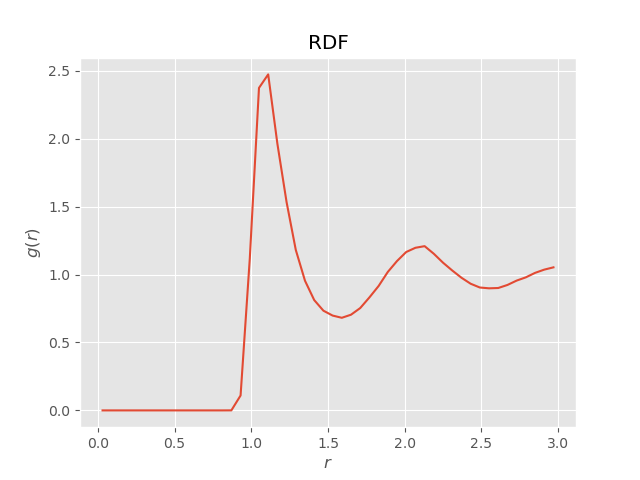

/Users/amoody/miniconda3/envs/icomse11/lib/python3.13/site-packages/freud/plot.py:280: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


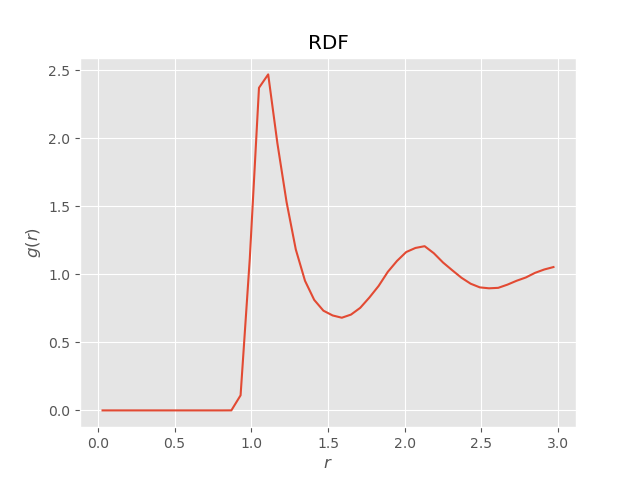

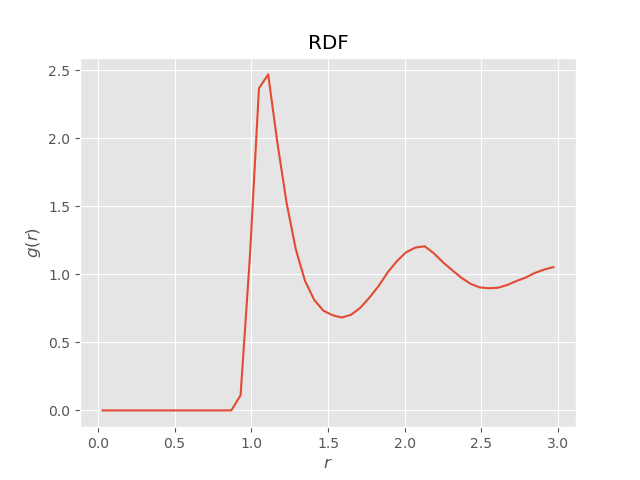

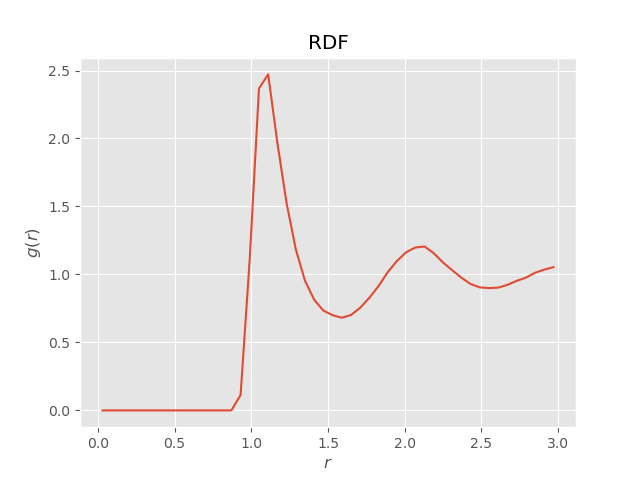

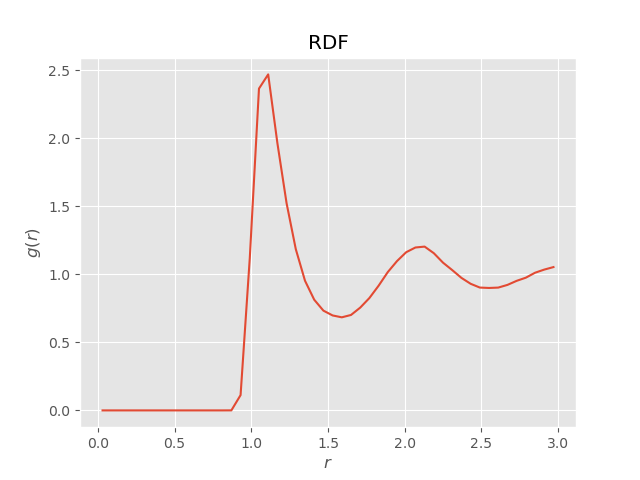

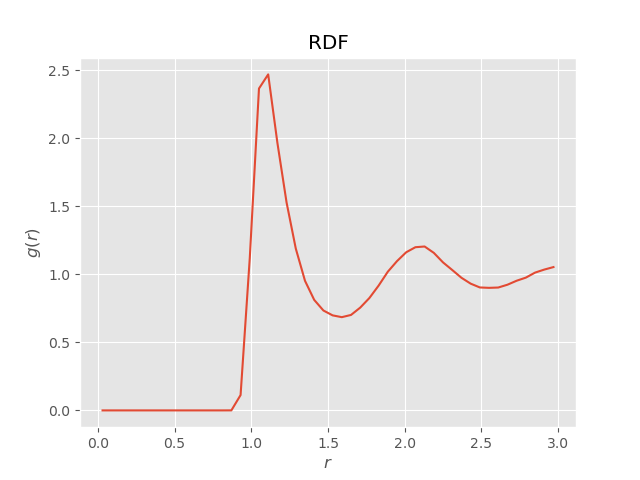

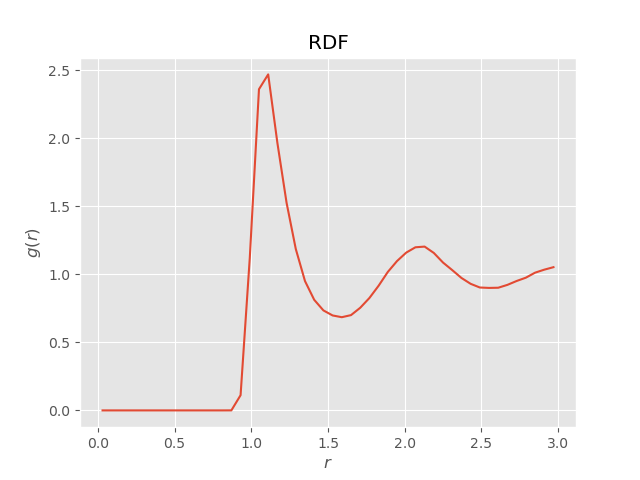

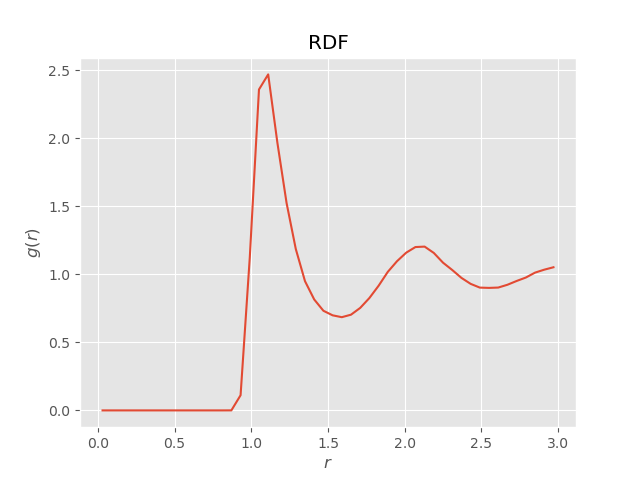

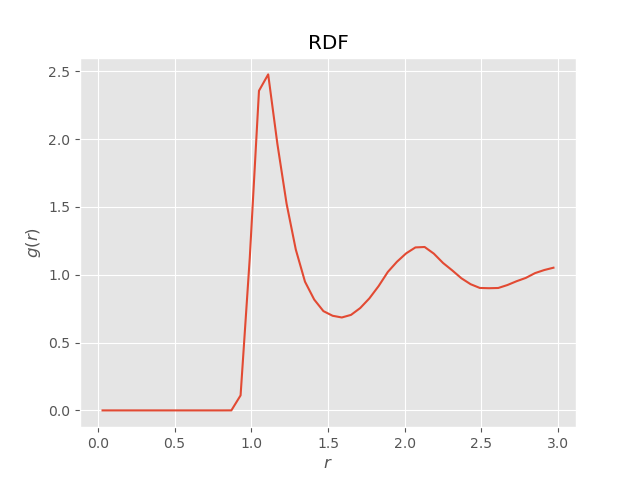

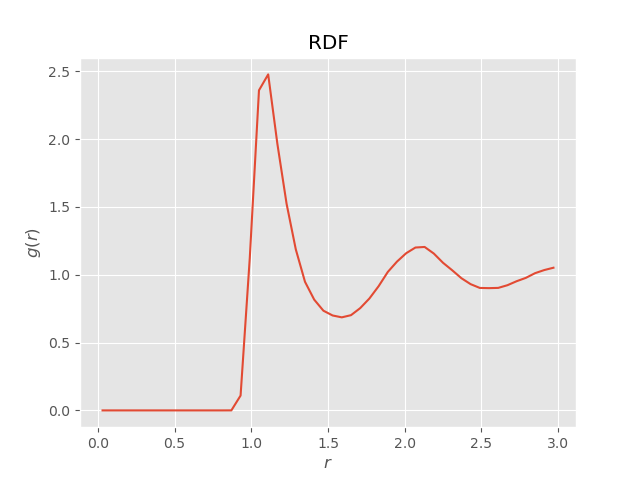

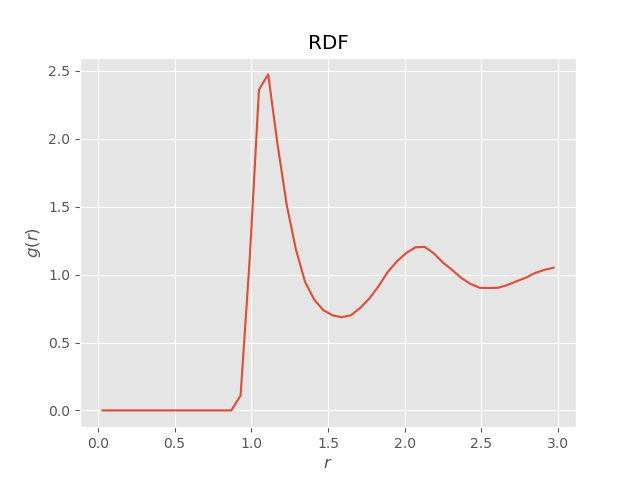

In [12]:
rdf = freud.density.RDF(bins=50, r_max=box[0]/4.)
for frame in trajectory[-30:]:
    points=frame.particles.position
    box = frame.configuration.box
    rdf.compute(system=(box, points), reset=False)

### Compare

Let's now compare our version with the freud version by plotting both of them: 

Text(0.5, 0, 'r')

Text(0, 0.5, 'g(r)')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

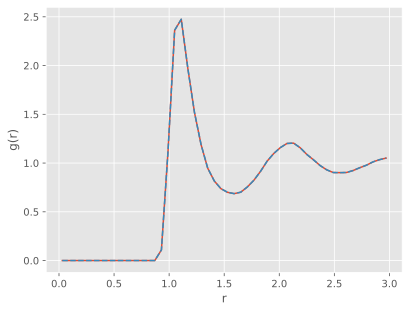

In [13]:
fig, ax = matplotlib.pyplot.subplots()

ax.plot(rdf.bin_centers, rdf.rdf)
ax.plot(c,hist_averaged,linestyle='dashed')
ax.set_xlabel('r')
ax.set_ylabel('g(r)')
matplotlib.pyplot.show()

### Additions 

1. Generate random uniform positions to sample configurations of an ideal gas. What is the $g(r)$ of an ideal gas? What is your expectation for the outcome and why? Can we use this to test our code?
2. Show how the $g(r)$ changes as function of temperature and/or density of the system.
3. What is the $g(r)$ of a perfect fcc crystal? *Hint:* You can use a similar setup to above to generate a fcc crystal. 

## Radius of Gyration of a Polymer

Now we want to calculate some structural quantities of polymers. We will use the radius of gyration (see [Rubinstein & Colby, Chapter 2.4](https://www.eng.uc.edu/~beaucag/Classes/Properties/Books/M.%20Rubinstein,%20Ralph%20H.%20Colby,%20-%20Polymer%20Physics%20(Chemistry)%20(2003).pdf)) $R_g$ as an example. 

To save some time, we will reach into the future and pretend we have run the simulations already. We will run some of them in the next session! For now, let's open a trajectory of a Gaussian chain model:  

In [14]:
trajectory = gsd.hoomd.open(name='../08-boundaries-periodic-2/run_len_50_pol_10.gsd', mode='r')

Let's render a movie of the trajectory to visualize what we are working with. The trajectory seems to be pretty long and has 10 polymers of length 80 in it. 

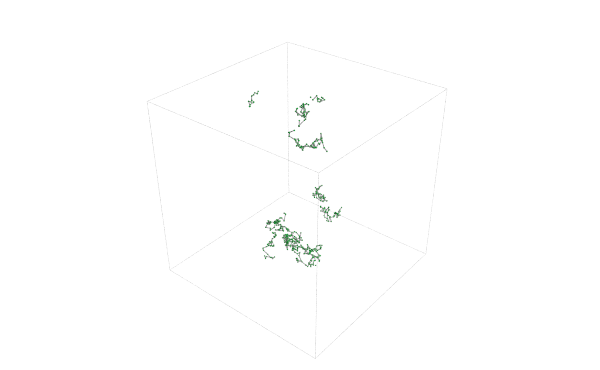

In [15]:
ims = []

a = render(trajectory[0])
im0 = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert("P", palette=PIL.Image.Palette.ADAPTIVE)
for frame in trajectory[1::500]:
    a = render(frame)
    im = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert("P", palette=PIL.Image.Palette.ADAPTIVE)
    ims.append(im)  

filename = 'test.gif'
im0.save(filename, "gif", save_all=True, append_images=ims, duration=20, loop=0)

with open(filename,'rb') as f:
    display.Image(data=f.read(), format='png')


Now we can compute the radius of gyration. For this, we do need to first unwrap the positions. Then, the positions need to be split (`numpy.split`) into seperate arrays, one per polymer.  Then we need to determine the center of mass of each polymer, and then calculate the $Rg^2$ of each polymer. Once the entire trajectory is processed, we can take the square root to get $R_g$. 

In [16]:
rg2 = []
timestep = []
for frame in trajectory:
    unwrapped_positions = frame.particles.position +\
                          frame.particles.image*frame.configuration.box[0:3]
    bonds =frame.bonds.group 
    polymer_delimiters = bonds[numpy.where((bonds[:-1,1]-bonds[1:,0])!=0)[0]+1][:,0]
    polymers  = numpy.split(unwrapped_positions,polymer_delimiters)
    for p in polymers:
        com = numpy.mean(p,axis=0)
        dist_pol_com =  p-com
        Rg2 = numpy.average(numpy.sum(dist_pol_com*dist_pol_com, axis=1))
        rg2.append(Rg2)
        timestep.append(frame.configuration.step)

Plot the results as function of timestep.

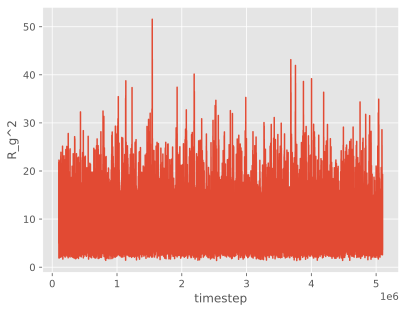

In [17]:
fig, ax = matplotlib.pyplot.subplots()

line = ax.plot(timestep,rg2)
xlabel = ax.set_xlabel('timestep')
ylabel = ax.set_ylabel('R_g^2')
matplotlib.pyplot.show()

Note that if you did ignore PBC (didn't apply minimum image convention, or didn't write out images, or didn't unwrap correctly etc.) then one could potentially see this in this time series as large spikes of unreasonably large values. 

It is also useful to plot time series to check if a system has equilibrated or if quantities are still changing. Here, we should be ok. 

From this times series, we can then compute the average $\langle R^2_g \rangle$, and then finally $\langle R_g \rangle$:

In [38]:
av_Rg2 = numpy.mean(rg2) 
av_Rg = numpy.sqrt(av_Rg2)
print("Rg=%1.2f"%(av_Rg))

Rg=3.65


The folder contains trajectories for $N=10,20,30,...100$. Determine their $R_g$ as function of *N*. **What scaling law do they follow?** *Hint:* Check Runbinstein and Colby for the appropriate formulas.

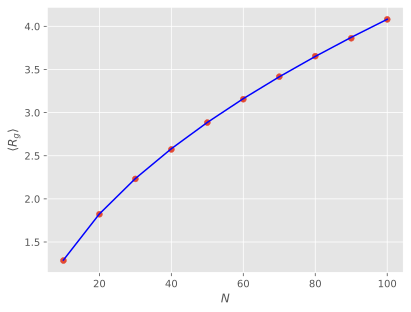

In [39]:
Ns = numpy.array([10,20,30,40,50,60,70,80,90,100])
av_Rg = []
for N in Ns:
    trajectory = gsd.hoomd.open(name='../08-boundaries-periodic-2/run_len_%s_pol_10.gsd'%N, mode='r')
    rg2 = []
    for frame in trajectory[:-500]:
        unwrapped_positions = frame.particles.position +\
                              frame.particles.image*frame.configuration.box[0:3]
        bonds =frame.bonds.group 
        polymer_delimiters = bonds[numpy.where((bonds[:-1,1]-bonds[1:,0])!=0)[0]+1][:,0]
        polymers  = numpy.split(unwrapped_positions,polymer_delimiters)
        for p in polymers:
            com = numpy.mean(p,axis=0)
            dist_pol_com =  p-com
            Rg2 = numpy.average(numpy.sum(dist_pol_com*dist_pol_com, axis=1))
            rg2.append(Rg2)
    av_Rg.append(numpy.sqrt(numpy.mean(rg2)))

fig, ax = matplotlib.pyplot.subplots()

points = ax.scatter(Ns,av_Rg)
line =ax.plot(Ns,(Ns/6)**(1/2),c='blue')
xlabel = ax.set_xlabel(r'$N$')
ylabel = ax.set_ylabel(r'$\langle R_g\rangle$')
matplotlib.pyplot.show()

### Additions 

1. The polymers are obviously "ideal" polymers, since they follow the scaling for ideal polymers perfectly. What would we have to do to make them "non-ideal" and change the effective solvent quality they are in?
2. What scaling laws do you expect polymers in different solvent qualities to follow? 

### More Additions

1. There is an alternative way to compute the COM that does not involve unwrapping with `images`. See [J. Chem. Phys. 162, 204103 (2025)]( https://doi.org/10.1063/5.0260928). Implement this algorithm.  

In [40]:
def com(a,Box):
    theta = numpy.divide(a + 0.5 * Box, Box)*numpy.multiply(2,numpy.pi)
    xi_average = numpy.average(numpy.cos(theta), axis = 0)
    zeta_average = numpy.average(numpy.sin(theta), axis = 0)
    theta_average = numpy.arctan2(-zeta_average,-xi_average) + numpy.pi
    com = numpy.multiply(Box,theta_average)/numpy.multiply(2,numpy.pi)-0.5 * Box
    return com
